In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
#1. Merge your ev_zip data onto the ZIP shapefile:

#zips = gpd.read_file("zip_poly.shp")
#ev = pd.read_csv("ev_zip.csv")
#zips_ev = zips.merge(ev, left_on="ZCTA5CE20"

In [8]:
#Merging zips and CALMAC GP centroids
zips = gpd.read_file("zip_codes/zip_poly.shp")
res_centroids = pd.read_csv("CALMAC/res_centroids.csv") 
res_centroids_gdf = gpd.GeoDataFrame(
    res_centroids,
    geometry=gpd.points_from_xy(res_centroids.longitude, res_centroids.latitude),
    crs="EPSG:4326")

In [10]:
zips = zips.to_crs(res_centroids_gdf.crs)

In [12]:
zip_gps = gpd.sjoin(res_centroids_gdf, zips, how="left", predicate="within")

In [14]:
zip_gps.sample(10)

,gp,latitude,longitude,geometry,index_right,ZIP_CODE,PO_NAME,STATE,POPULATION,POP_SQMI,SQMI
96,3_3_NS_C,37.63269,-122.2165,POINT (-122.2165 37.63269),NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,2_4_S_I,37.61434,-122.0755,POINT (-122.0755 37.61434),1079.0,94545,Hayward,CA,33248.0,2599.53,12.79
59,2_3_NS_S,36.21054,-119.4913,POINT (-119.4913 36.21054),775.0,93274,Tulare,CA,80733.0,376.18,214.61
26,1_4_NS_N,38.32250,-121.3839,POINT (-121.3839 38.3225),1568.0,95757,Elk Grove,CA,59517.0,831.82,71.55
131,4_2_NS_S,36.14948,-119.4878,POINT (-119.4878 36.14948),775.0,93274,Tulare,CA,80733.0,376.18,214.61
56,2_3_NS_C,37.66875,-122.2329,POINT (-122.2329 37.66875),NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,1_3_NS_I,37.64475,-122.1194,POINT (-122.1194 37.64475),1079.0,94545,Hayward,CA,33248.0,2599.53,12.79
155,4_5_NS_S,36.26122,-119.5177,POINT (-119.5177 36.26122),775.0,93274,Tulare,CA,80733.0,376.18,214.61
33,1_5_NS_I,37.99419,-122.3610,POINT (-122.361 37.99419),NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,2_5_NS_S,36.32005,-119.5653,POINT (-119.5653 36.32005),744.0,93230,Hanford,CA,69913.0,256.97,272.07


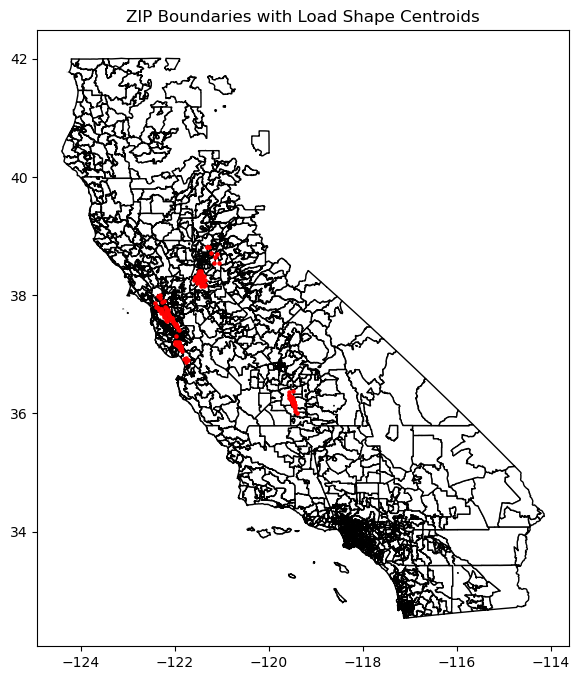

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
zips.plot(ax=ax, color="white", edgecolor="black")        # ZIP boundaries
zip_gps.plot(ax=ax, color="red", markersize=5)             # centroid points
plt.title("ZIP Boundaries with Load Shape Centroids")
plt.show()

In [16]:
#alright this was the incorrect method. I actually need to assign each of the GPs to one of the CEC's climate zones. 
# Then I will merge ZIP shapefiles with Climate zones so I can assign GPs to each california zip code. 
# from CALMAC gp data description:
#Climate Zone Groups
#To improve reporting across a wider variety of weather conditions, both commercial and residential granular profiles will now be produced for each of four climate zone groups:
#Coastal (Zones 1, 3, and 5)
#Inland (Zones 2 and 4)
#North Central Valley (Zones 11 and 12)
#South Central Valley (Zone 13)




EPSG:4326
EPSG:4326


In [25]:
# Load shapefile of CEC climate zones
climate_zones = gpd.read_file("CALMAC/Building_Climate_Zones.shp")
zips = gpd.read_file("zip_codes/zip_poly.shp")

#mapping climate zones to CALMAC territories, from CALMAC data description
cz_groups = {
    1: "Coastal", 3: "Coastal", 5: "Coastal",
    2: "Inland", 4: "Inland",
    11: "North Central Valley", 12: "North Central Valley",
    13: "South Central Valley"
}
climate_zones["BZone"] = climate_zones["BZone"].astype(int)
climate_zones["cz_groups"] = climate_zones["BZone"].map(cz_groups) #BZone is the CEC column with numeric climate zones

zips = zips.to_crs(climate_zones.crs)
zips["centroid"] = zips.centroid #need to find zip centroids to theres only one climate zone per ZIP
zips_centroids = zips.set_geometry("centroid")
zips_climate = gpd.sjoin(zips_centroids, climate_zones, how="left", predicate="within")
zips_climate = zips_climate[zips_climate["cz_groups"].notna()].copy()
# Load CALMAC characteristics 
res_chars = pd.read_csv("CALMAC/res_characteristics.csv")
nonres_chars = pd.read_csv("CALMAC/nonres_characteristics.csv")
# Combine res and nonres GPs, create 'type' column
res_chars["type"] = "residential"
nonres_chars["type"] = "nonresidential"
gps_all = pd.concat([res_chars, nonres_chars], ignore_index=True)

# Group by CALMAC climate zone 
gps_by_zone = gps_all.groupby("seg_cz")["gp"].apply(list).reset_index()
gps_by_zone.rename(columns={"gp": "gp_list"}, inplace=True)

zips_final = zips_climate.merge(
    gps_by_zone, left_on="cz_groups", right_on="seg_cz", how="left"
)
zips_final = zips_final.drop(columns=["PO_NAME", "STATE", "index_right", "BAcerage" ])


In [26]:
print(climate_zones.columns)

Index(['BZone', 'BAcerage', 'geometry', 'cz_groups'], dtype='object')


In [27]:

zips_final.sample(10)

,ZIP_CODE,POPULATION,POP_SQMI,SQMI,geometry,centroid,BZone,cz_groups,seg_cz,gp_list
368,94804,45458,6815.29,6.67,"MULTIPOLYGON (((-209203.799 -7491.968, -209198...",POINT (-205558.414 -8069.344),3.0,Coastal,Coastal,"[1_1_NS_C, 2_1_NS_C, 3_1_NS_C, 4_1_NS_C, 1_2_N..."
679,95607,278,4.84,57.42,"POLYGON ((-191602.597 77747.632, -191602.465 7...",POINT (-183311.843 78538.115),12.0,North Central Valley,North Central Valley,"[1_1_NS_N, 2_1_NS_N, 3_1_NS_N, 4_1_NS_N, 1_2_N..."
498,95237,3442,272.31,12.64,"POLYGON ((-103960.798 14177.596, -103957.179 1...",POINT (-99177.195 17062.51),12.0,North Central Valley,North Central Valley,"[1_1_NS_N, 2_1_NS_N, 3_1_NS_N, 4_1_NS_N, 1_2_N..."
730,95679,36,1.39,25.97,"POLYGON ((-209827.692 101004.015, -209808.746 ...",POINT (-203687.687 100309.442),12.0,North Central Valley,North Central Valley,"[1_1_NS_N, 2_1_NS_N, 3_1_NS_N, 4_1_NS_N, 1_2_N..."
424,95033,9302,87.51,106.30,"POLYGON ((-190979.872 -78303.953, -190920.225 ...",POINT (-172898.527 -95181.701),4.0,Inland,Inland,"[1_1_NS_I, 2_1_NS_I, 3_1_NS_I, 4_1_NS_I, 1_2_N..."
760,95811,11906,5486.64,2.17,"POLYGON ((-131244.253 65563.328, -131189.515 6...",POINT (-129595.628 64577.938),12.0,North Central Valley,North Central Valley,"[1_1_NS_N, 2_1_NS_N, 3_1_NS_N, 4_1_NS_N, 1_2_N..."
32,93250,15548,89.76,173.22,"POLYGON ((60510.795 -263336.233, 60511.139 -26...",POINT (76484.508 -261750.173),13.0,South Central Valley,South Central Valley,"[1_1_NS_S, 2_1_NS_S, 3_1_NS_S, 4_1_NS_S, 1_2_N..."
728,95677,28570,3181.51,8.98,"POLYGON ((-110022.606 87154.116, -109966.431 8...",POINT (-106844.113 86876.108),11.0,North Central Valley,North Central Valley,"[1_1_NS_N, 2_1_NS_N, 3_1_NS_N, 4_1_NS_N, 1_2_N..."
12,93207,454,3.63,125.19,"POLYGON ((80450.431 -237369.626, 80448.092 -23...",POINT (99315.994 -240396.297),13.0,South Central Valley,South Central Valley,"[1_1_NS_S, 2_1_NS_S, 3_1_NS_S, 4_1_NS_S, 1_2_N..."
771,95824,30864,7813.67,3.95,"POLYGON ((-128856.403 57529.492, -128815.128 5...",POINT (-125511.262 56683.894),12.0,North Central Valley,North Central Valley,"[1_1_NS_N, 2_1_NS_N, 3_1_NS_N, 4_1_NS_N, 1_2_N..."


In [21]:
print("Unique cz_groups in zips_climate:", zips_climate["cz_groups"].unique())
print("Unique seg_cz in gps_by_zone:", gps_by_zone["seg_cz"].unique())



Unique cz_groups in zips_climate: []
Unique seg_cz in gps_by_zone: ['Coastal' 'Inland' 'North Central Valley' 'South Central Valley']


In [22]:
print(climate_zones["BZone"].unique())
print(climate_zones["cz_groups"].unique())


['1' '10' '11' '12' '13' '14' '15' '16' '2' '3' '4' '5' '6' '7' '8' '9']
[nan]
